In [1]:
import sys

sys.path.append("..")
sys.path.append("../../")
sys.path.append("../../src")

import os
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functional_autoencoders.datasets import get_dataloaders, ComplementMasking
from functional_autoencoders.datasets.navier_stokes import NavierStokes
from functional_autoencoders.util import pickle_load

# %load_ext autoreload
# %autoreload 2

key = jax.random.PRNGKey(42)

In [2]:
MODEL_NAME = "fvae_ns_1e-4_small"
VISCOSITY = 1e-4
DOWNSCALE = 16
LATENT_DIM = 32
DATASET_S = 2
MAX_STEP = 50_000
BETA = 1e-9
MMD_N_SAMPLES = 128
RATIO_RAND_PTS_ENC = 0.5
LR = 1e-3
LR_DECAY_FACTOR = 0.98

mask_train = ComplementMasking(RATIO_RAND_PTS_ENC)
train_dataloader, test_dataloader = get_dataloaders(
    NavierStokes,
    batch_size=32,
    data_base="../..",
    viscosity=VISCOSITY,
    resolution=64,
    transform_train=mask_train,
    load_fast=True,
    save_fast=True,
)

In [3]:
def get_raw_x(n, device=None):
    x_mesh_list = jnp.meshgrid(
        jax.device_put(jnp.linspace(0, 1, n + 2)[1:-1], device),
        jax.device_put(jnp.linspace(0, 1, n + 2)[1:-1], device),
        indexing="ij",
    )
    xx = jnp.concatenate([jnp.expand_dims(v, -1) for v in x_mesh_list], axis=-1)
    xx = xx.reshape(-1, 2)
    return xx

In [4]:
MODEL_OUT_DIR = "../../tmp/experiments/sparse_training/models"
heavy_results = pickle_load(os.path.join(MODEL_OUT_DIR, "model.pkl"))

autoencoder = heavy_results["autoencoder"]
results = heavy_results["results"]

In [5]:
state = results["state"]
u, x, _, _ = next(iter(test_dataloader))

  0%|          | 0/1000 [00:00<?, ?it/s]

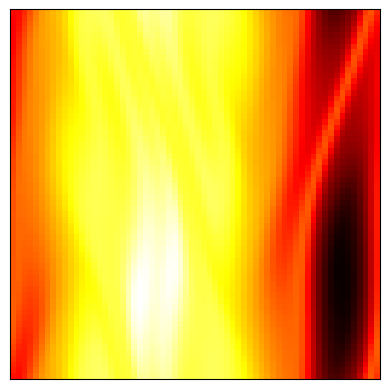

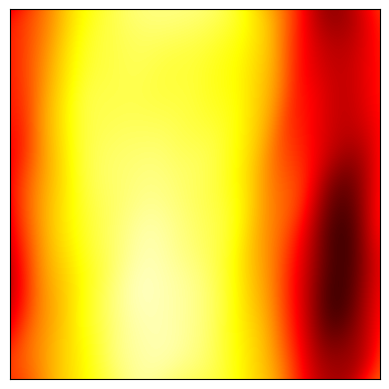

  0%|          | 0/1000 [00:00<?, ?it/s]

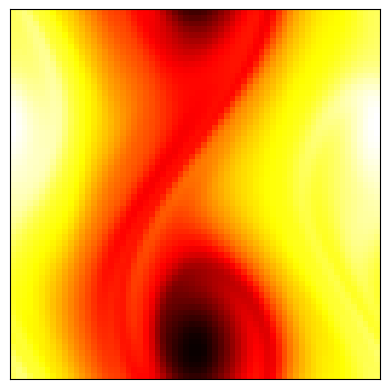

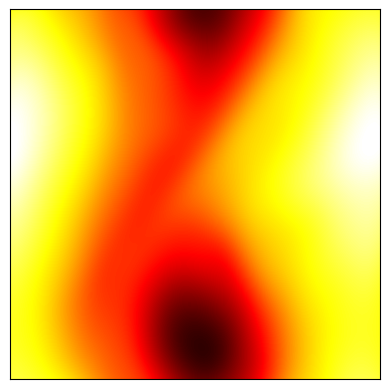

In [6]:
IDX_LIST = [0, 1]
N_REC = 2048
N_SPLITS = 1000
SAVE_DIR = None
# SAVE_DIR = '../../figures/sparse_training/very_high_resolution'
# os.makedirs(SAVE_DIR, exist_ok=True)

for idx in IDX_LIST:
    u_base = u[idx : idx + 1]
    x_base = x[idx : idx + 1]

    vmin = jnp.min(u_base)
    vmax = jnp.max(u_base)

    n = int(u_base.shape[1] ** 0.5)

    z = autoencoder.encode(state, u_base, x_base)

    outputs = []
    x_rec = get_raw_x(N_REC, jax.devices("cpu")[0])[None, ...]

    # move x_rec to CPU
    x_rec = jax.device_put(x_rec, jax.devices("cpu")[0])

    for x_batch in tqdm(jnp.array_split(x_rec, N_SPLITS, axis=1)):
        x_batch = jax.device_put(x_batch, jax.devices("gpu")[0])
        u_rec_split = autoencoder.decode(state, z, x_batch)
        outputs.append(jax.device_put(u_rec_split, jax.devices("cpu")[0]))

    u_rec_split = jnp.concatenate(outputs, axis=1)
    u_final = u_rec_split[0]

    plt.imshow(u_base.reshape(n, n), cmap="hot", vmin=vmin, vmax=vmax)
    plt.xticks([])
    plt.yticks([])
    if SAVE_DIR is not None:
        plt.savefig(f"{SAVE_DIR}/original_{n}_{idx}.pdf")
    plt.show()

    plt.imshow(u_final.reshape(N_REC, N_REC), cmap="hot", vmin=vmin, vmax=vmax)
    plt.xticks([])
    plt.yticks([])
    if SAVE_DIR is not None:
        plt.colorbar()
        plt.savefig(f"{SAVE_DIR}/super_{N_REC}_{idx}.pdf")
    plt.show()

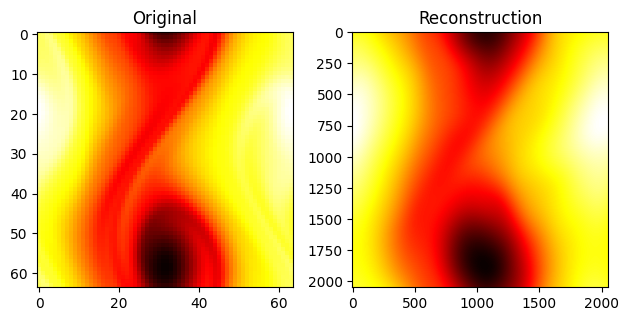

In [7]:
plt.subplot(1, 2, 1)
plt.imshow(u_base.reshape(n, n), cmap="hot")
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(u_final.reshape(N_REC, N_REC), cmap="hot")
plt.title("Reconstruction")

plt.tight_layout()
plt.show()